<a href="https://colab.research.google.com/github/SVGS-EVA4/Phase2/blob/master/S2-MobileNets_and_ShuffleNets/Extras/Shilpa/E4p2_s2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!pip install torch==1.5.1+cu92 torchvision==0.6.1+cu92 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 604.8MB 29kB/s 
     |████████████████████████████████| 6.5MB 42.3MB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101


In [3]:
!pip install torchsummary
!pip install -U git+https://github.com/albu/albumentations

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-ile9y8qa
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-ile9y8qa
     |████████████████████████████████| 952kB 7.2MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=65819 sha256=2c7e770ae628081a6725defd58d2b7fe920cae4f2652399badc043c93a640f32
  Stored in directory: /tmp/pip-ephem-wheel-cache-owea4kaw/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


# Loading the dataset

In [4]:
# data loader
from torch.utils.data import Dataset
import random
import numpy as np
import torch
from PIL import Image

def unzip_files(filename = '/content/gdrive/My Drive/e4p2/dataset.zip'):
  
  from zipfile import ZipFile 
  import os

  # opening the zip file in READ mode 
  with ZipFile(filename, 'r') as zip_file: 
    
      # extracting all the files 
      print('Extracting all the files now...') 
      zip_file.extractall() 
      print('Done!')

def get_data(label_file='/content/gdrive/My Drive/e4p2/labels_num.txt',length=None):
    images = []
    target = []
    
    if length == None:
      labels = (open(label_file,'r')).readlines()
    else:
      labels = (open(label_file,'r')).readlines()[:length]
    for label in labels:
      a  = label.split(' ')
      images.append(f'/content/Dataset/{a[0]}')
      l = a[1].split('\n')
      target.append(l[0])         
    dataset =  list(zip(images,target))
    random.shuffle(dataset)
    train_split = 70
    train_len = len(dataset)*train_split//100
    train = dataset[:train_len]
    test = dataset[train_len:]
    return train,test

class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.transform = transform
        
        self.input_images,target = zip(*data) 
        self.target = np.asarray(target)
        self.target = torch.from_numpy(self.target.astype('long'))

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
  
        # print(self.target[idx],'---',idx,'----')
        input_image = np.asarray(Image.open(self.input_images[idx]))
        target = self.target[idx]
        
        if self.transform:
            input_image = self.transform(image=input_image)['image']
                    
        return input_image,target

def form_data(length =None, train_transform =None,test_transform =None):
  import os
  if 'Dataset' not in os.listdir('/content'):
    unzip_files(filename='/content/gdrive/My Drive/e4p2/dataset_padded.zip')
  else:
    print('Files already downloaded')
  print('Forming the dataset')
  train, test = get_data(length=length)

  train_set = CustomDataset(train,transform=train_transform )
  test_set = CustomDataset(test,transform=test_transform )
  print('Done!')
  return train_set, test_set

In [5]:
# augmentations
import albumentations as A
import albumentations.pytorch as AP

mean = (0.53105756 , 0.58601165 , 0.61593276)

std = (0.28278487,  0.25762487 , 0.29407342)
	
train_transform = A.Compose(
    [ 
     
     A.Resize(224, 224, interpolation=1, always_apply=True, p=1),
     A.Flip(always_apply=False, p=0.5), 
     A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.1, rotate_limit=45, 
                        interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
     A.RandomContrast(limit=0.2, always_apply=False, p=0.5),
    #  A.ChannelShuffle(always_apply=False, p=0.5),
    #  A.GridDistortion(num_steps=5, distort_limit=0.3, interpolation=1, border_mode=4,
    #                   value=None, mask_value=None, always_apply=False, p=0.5),
     A.Cutout(num_holes=4, max_h_size=32,max_w_size = 32,p=1,fill_value=0.5*255), 
     A.Normalize(mean=mean, std=std),
     AP.ToTensor()        
             ])
            
test_transform = A.Compose(
    [ 
     A.Resize(224, 224, interpolation=1, always_apply=True, p=1),
     A.Normalize(mean=mean, std=std),
     AP.ToTensor()        
             ])



In [6]:
train_set,test_set = form_data( train_transform=train_transform, test_transform=test_transform )                                        

Extracting all the files now...
Done!
Forming the dataset
Done!


In [7]:
# %%file data_load.py

import torch
import torchvision



def load(train_set,test_set,seed=1,batch_size=128,num_workers=4,pin_memory=True):
	
	SEED = 1

	# CUDA?
	cuda = torch.cuda.is_available()


	# For reproducibility
	torch.manual_seed(SEED)

	if cuda:
			torch.cuda.manual_seed(SEED)

	# dataloader arguments - something you'll fetch these from cmdprmt
	dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory) if cuda else dict(shuffle=True, batch_size=64)

	trainloader = torch.utils.data.DataLoader(train_set, **dataloader_args)
	testloader = torch.utils.data.DataLoader(test_set, **dataloader_args)


	return  trainloader, testloader

In [8]:
trainloader,testloader = load(train_set,test_set,batch_size=128)

# Display the images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape: torch.Size([128, 3, 224, 224])
Winged_Drones Winged_Drones Winged_Drones Large_QuadCopters Flying_Birds


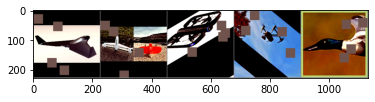

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision

classes = ['Winged_Drones', 'Small_QuadCopters', 'Large_QuadCopters', 'Flying_Birds' ]
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))



def show_random_images(dataset, classes):

	# get some random training images
	dataiter = iter(dataset)
	images, labels = dataiter.next()

	img_list = range(5, 10)

	# show images
	print('shape:', images.shape)
	imshow(torchvision.utils.make_grid(images[img_list]))
	# print labels
  
	print(' '.join('%5s' % classes[int(labels[j])] for j in img_list))
 
show_random_images(trainloader, classes)

# Loading the model

In [9]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)


cuda


In [10]:
from torchsummary import summary

In [10]:
model = torch.hub.load('pytorch/vision', 'mobilenet_v2', pretrained=True).to(device)

Downloading: "https://github.com/pytorch/vision/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


In [12]:
model

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [29]:
# # Freeze model weights
# for param in model.parameters():
#     param.requires_grad = False

In [11]:
import torch.nn as nn
# model.classifier[1] = nn.Linear(in_features=1280, out_features=4, bias=True).cuda()
model.classifier[1] = nn.Sequential(
                      nn.Linear(1280, 256), 
                      nn.ReLU(), 
                      # nn.Dropout(0.4),
                      nn.Linear(256, 4),                   
                      ).cuda()

In [31]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [32]:
# %load_ext tensorboard

In [33]:
# from torch.utils.tensorboard import SummaryWriter
# tb = SummaryWriter(flush_secs=5)
# data,target = next(iter(trainloader))
# data,target = data.to(device), target.to(device)
# tb.add_graph(model,data)
# tb.close()

In [34]:
# %tensorboard --logdir=runs

# Training and testing

In [14]:

class Train_test:
  
  def __init__(self):
    self.train_losses = []
    self.test_losses = []
    self.train_acc = []
    self.test_acc = []
    self.train_acc_epoch_end = []
    self.train_loss_epoch_end = []

  def train_and_test(self,model, device, train_loader,test_loader, optimizer, criterion, epoch):
      
    
    self.train_acc,self.train_acc_epoch_end,self.train_losses,self.train_loss_epoch_end = self.train(model, device, train_loader, optimizer, criterion)
    self.test_losses,self.test_acc = self.test(model, device, criterion, test_loader)
    return self.train_acc,self.train_acc_epoch_end,self.train_losses,self.train_loss_epoch_end,self.test_losses,self.test_acc


  def train(self,model, device, train_loader, optimizer, criterion):

    import torch
    #Training & Testing Loops
    from tqdm import tqdm

    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
      # get samples
      # target = np.asarray(target)
      # target = torch.from_numpy(target.astype('long'))
      data, target = data.to(device), target.to(device)

      # Init
      optimizer.zero_grad()
      # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
      # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

      # Predict
      y_pred = model(data)

      # Calculate loss
      # loss = F.nll_loss(y_pred, target)
      loss = criterion(y_pred, target)
      self.train_losses.append(loss)

      # Backpropagation
      loss.backward()
      optimizer.step()

      # Update pbar-tqdm
      
      pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()
      processed += len(data)

      pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
      self.train_acc.append(100*correct/processed)
    self.train_acc_epoch_end.append(self.train_acc[-1])
    self.train_loss_epoch_end.append(self.train_losses[-1])
    return self.train_acc,self.train_acc_epoch_end,self.train_losses,self.train_loss_epoch_end


  def test(self,model, device, criterion, test_loader):

      import torch
    #Training & Testing Loops
      from tqdm import tqdm

      model.eval()
      test_loss = 0
      correct = 0
      with torch.no_grad():
          for data, target in test_loader:
              # target = np.asarray(target)
              # target = torch.from_numpy(target.astype('long'))
              data, target = data.to(device), target.to(device)
              output = model(data)
              test_loss += criterion(output, target).item()  # sum up batch loss
              pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
              correct += pred.eq(target.view_as(pred)).sum().item()
              

      test_loss /= len(test_loader.dataset)
      self.test_losses.append(test_loss)

      print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
          test_loss, correct, len(test_loader.dataset),
          100. * correct / len(test_loader.dataset)))
      
      self.test_acc.append(100. * correct / len(test_loader.dataset))
      return self.test_losses,self.test_acc

def save_model(epoch , model, optimizer, best_loss,best_acc,path ):

  print(f'Saving Model to {path}')
  torch.save({
            'epoch': epoch,
            'state_dict': model,
            'best_test_loss': best_loss,
            'best_test_acc': best_acc,
            'optimizer' : optimizer,
        }, path)

In [12]:
# import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler

In [37]:
# model = torch.hub.load('pytorch/vision', 'mobilenet_v2', pretrained=True).to(device)
# model.classifier[1] = nn.Linear(in_features=1280, out_features=4, bias=True).cuda()

In [38]:
# use_cuda = torch.cuda.is_available()
# device = torch.device("cuda" if use_cuda else "cpu")


EPOCHS = 20
l_rate = []
optimizer = optim.SGD(model.parameters(), lr=0.001,momentum=0.9) 
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5, last_epoch=-1)
train_test = Train_test()
best_test_acc = 0

from datetime import datetime
today = datetime.now()
path = f'/content/gdrive/My Drive/e4p2/e4p2_s2_model_{str(today)}.pt'

for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1, 'LR:',optimizer.param_groups[0]['lr'])
    l_rate.append(optimizer.param_groups[0]['lr'] )
    train_acc,train_acc_epoch_end,train_losses,train_loss_epoch_end,test_losses,test_acc = train_test.train_and_test(model, device, trainloader,testloader, optimizer, criterion, epoch)
    if test_acc[-1] > best_test_acc:     
      save_model(epoch+1 , model.state_dict(), optimizer, test_losses[-1],test_acc[-1],path)
      
    scheduler.step()

  0%|          | 0/117 [00:00<?, ?it/s]

EPOCH: 1 LR: 0.001


Loss=0.7227893471717834 Batch_id=116 Accuracy=58.06: 100%|██████████| 117/117 [04:26<00:00,  2.28s/it]
  0%|          | 0/117 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 5071/6401 (79.22%)

Saving Model to /content/gdrive/My Drive/e4p2/e4p2_s2_model_2020-08-07 19:15:01.159593.pt
EPOCH: 2 LR: 0.001


Loss=0.6154137253761292 Batch_id=116 Accuracy=77.53: 100%|██████████| 117/117 [04:26<00:00,  2.28s/it]
  0%|          | 0/117 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 5278/6401 (82.46%)

Saving Model to /content/gdrive/My Drive/e4p2/e4p2_s2_model_2020-08-07 19:15:01.159593.pt
EPOCH: 3 LR: 0.001


Loss=0.3893522024154663 Batch_id=116 Accuracy=80.54: 100%|██████████| 117/117 [04:25<00:00,  2.27s/it]
  0%|          | 0/117 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 5379/6401 (84.03%)

Saving Model to /content/gdrive/My Drive/e4p2/e4p2_s2_model_2020-08-07 19:15:01.159593.pt
EPOCH: 4 LR: 0.001


Loss=0.46394553780555725 Batch_id=116 Accuracy=82.36: 100%|██████████| 117/117 [04:24<00:00,  2.26s/it]
  0%|          | 0/117 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 5392/6401 (84.24%)

Saving Model to /content/gdrive/My Drive/e4p2/e4p2_s2_model_2020-08-07 19:15:01.159593.pt
EPOCH: 5 LR: 0.001


Loss=0.35542625188827515 Batch_id=116 Accuracy=83.25: 100%|██████████| 117/117 [04:25<00:00,  2.27s/it]
  0%|          | 0/117 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 5405/6401 (84.44%)

Saving Model to /content/gdrive/My Drive/e4p2/e4p2_s2_model_2020-08-07 19:15:01.159593.pt
EPOCH: 6 LR: 0.001


Loss=0.3977579176425934 Batch_id=116 Accuracy=83.87: 100%|██████████| 117/117 [04:25<00:00,  2.27s/it]
  0%|          | 0/117 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 5503/6401 (85.97%)

Saving Model to /content/gdrive/My Drive/e4p2/e4p2_s2_model_2020-08-07 19:15:01.159593.pt
EPOCH: 7 LR: 0.001


Loss=0.413866251707077 Batch_id=116 Accuracy=84.63: 100%|██████████| 117/117 [04:26<00:00,  2.27s/it]
  0%|          | 0/117 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 5538/6401 (86.52%)

Saving Model to /content/gdrive/My Drive/e4p2/e4p2_s2_model_2020-08-07 19:15:01.159593.pt
EPOCH: 8 LR: 0.001


Loss=0.36282989382743835 Batch_id=116 Accuracy=84.92: 100%|██████████| 117/117 [04:27<00:00,  2.29s/it]
  0%|          | 0/117 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 5543/6401 (86.60%)

Saving Model to /content/gdrive/My Drive/e4p2/e4p2_s2_model_2020-08-07 19:15:01.159593.pt
EPOCH: 9 LR: 0.001


Loss=0.2208292931318283 Batch_id=116 Accuracy=85.19: 100%|██████████| 117/117 [04:27<00:00,  2.29s/it]
  0%|          | 0/117 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 5547/6401 (86.66%)

Saving Model to /content/gdrive/My Drive/e4p2/e4p2_s2_model_2020-08-07 19:15:01.159593.pt
EPOCH: 10 LR: 0.001


Loss=0.2430727332830429 Batch_id=116 Accuracy=85.78: 100%|██████████| 117/117 [04:30<00:00,  2.32s/it]
  0%|          | 0/117 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 5540/6401 (86.55%)

Saving Model to /content/gdrive/My Drive/e4p2/e4p2_s2_model_2020-08-07 19:15:01.159593.pt
EPOCH: 11 LR: 0.001


Loss=0.39890241622924805 Batch_id=116 Accuracy=86.29: 100%|██████████| 117/117 [04:27<00:00,  2.29s/it]
  0%|          | 0/117 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 5586/6401 (87.27%)

Saving Model to /content/gdrive/My Drive/e4p2/e4p2_s2_model_2020-08-07 19:15:01.159593.pt
EPOCH: 12 LR: 0.001


Loss=0.3697931468486786 Batch_id=116 Accuracy=86.77: 100%|██████████| 117/117 [04:28<00:00,  2.30s/it]
  0%|          | 0/117 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 5624/6401 (87.86%)

Saving Model to /content/gdrive/My Drive/e4p2/e4p2_s2_model_2020-08-07 19:15:01.159593.pt
EPOCH: 13 LR: 0.001


Loss=0.30757948756217957 Batch_id=116 Accuracy=86.95: 100%|██████████| 117/117 [04:28<00:00,  2.29s/it]
  0%|          | 0/117 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 5661/6401 (88.44%)

Saving Model to /content/gdrive/My Drive/e4p2/e4p2_s2_model_2020-08-07 19:15:01.159593.pt
EPOCH: 14 LR: 0.001


Loss=0.3186260163784027 Batch_id=116 Accuracy=87.33: 100%|██████████| 117/117 [04:30<00:00,  2.31s/it]
  0%|          | 0/117 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 5634/6401 (88.02%)

Saving Model to /content/gdrive/My Drive/e4p2/e4p2_s2_model_2020-08-07 19:15:01.159593.pt
EPOCH: 15 LR: 0.001


Loss=0.2824682891368866 Batch_id=116 Accuracy=87.76: 100%|██████████| 117/117 [04:30<00:00,  2.31s/it]
  0%|          | 0/117 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 5668/6401 (88.55%)

Saving Model to /content/gdrive/My Drive/e4p2/e4p2_s2_model_2020-08-07 19:15:01.159593.pt
EPOCH: 16 LR: 0.001


Loss=0.3426499366760254 Batch_id=116 Accuracy=87.99: 100%|██████████| 117/117 [04:28<00:00,  2.29s/it]
  0%|          | 0/117 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 5668/6401 (88.55%)

Saving Model to /content/gdrive/My Drive/e4p2/e4p2_s2_model_2020-08-07 19:15:01.159593.pt
EPOCH: 17 LR: 0.001


Loss=0.3957272171974182 Batch_id=116 Accuracy=88.39: 100%|██████████| 117/117 [04:29<00:00,  2.30s/it]
  0%|          | 0/117 [00:00<?, ?it/s]


Test set: Average loss: 0.0024, Accuracy: 5684/6401 (88.80%)

Saving Model to /content/gdrive/My Drive/e4p2/e4p2_s2_model_2020-08-07 19:15:01.159593.pt
EPOCH: 18 LR: 0.001


Loss=0.20922543108463287 Batch_id=116 Accuracy=88.93: 100%|██████████| 117/117 [04:29<00:00,  2.30s/it]
  0%|          | 0/117 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 5687/6401 (88.85%)

Saving Model to /content/gdrive/My Drive/e4p2/e4p2_s2_model_2020-08-07 19:15:01.159593.pt
EPOCH: 19 LR: 0.001


Loss=0.20646868646144867 Batch_id=116 Accuracy=88.88: 100%|██████████| 117/117 [04:30<00:00,  2.31s/it]
  0%|          | 0/117 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 5690/6401 (88.89%)

Saving Model to /content/gdrive/My Drive/e4p2/e4p2_s2_model_2020-08-07 19:15:01.159593.pt
EPOCH: 20 LR: 0.001


Loss=0.23930372297763824 Batch_id=116 Accuracy=89.13: 100%|██████████| 117/117 [04:28<00:00,  2.30s/it]



Test set: Average loss: 0.0023, Accuracy: 5714/6401 (89.27%)

Saving Model to /content/gdrive/My Drive/e4p2/e4p2_s2_model_2020-08-07 19:15:01.159593.pt


In [39]:
path = f'/content/gdrive/My Drive/e4p2/e4p2_s2_model_best_cpu1.pt'
model.to('cpu')
model.eval()
traced_model = torch.jit.trace(model,torch.randn(1,3,244,244)) 
traced_model.save(path)


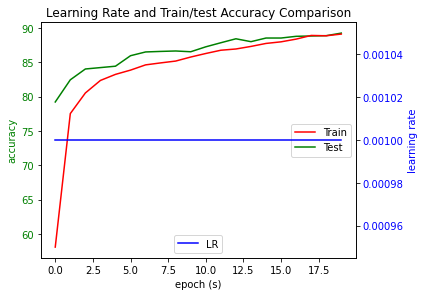

In [40]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

ax1.set_xlabel('epoch (s)')
ax1.set_ylabel('accuracy', color='g')
testline, = ax1.plot( test_acc, color='g')
ax1.tick_params(axis='y', labelcolor='g')

trainline, = ax1.plot( train_acc_epoch_end, color='r')
ax1.legend((trainline, testline), ('Train', 'Test'), loc=7)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis


ax2.set_ylabel('learning rate', color='b')  # we already handled the x-label with ax1
lrline, = ax2.plot( l_rate, color='b')
ax2.legend((lrline, ), ('LR',), loc=8)
ax2.tick_params(axis='y', labelcolor='b')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Learning Rate and Train/test Accuracy Comparison")
plt.show()

In [42]:
# classwise accuracy


def evaluate_classwise_accuracy(model, device, classes, test_loader):
    class_correct = list(0. for i in range(4))
    class_total = list(0. for i in range(4))
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            batch = c.size()
            if len(batch)==0:
              break
            for i in range(batch[0]):
            	label = labels[i]
            	class_correct[label] += c[i].item()
            	class_total[label] += 1

    for i in range(4):
        print(f'Accuracy of {classes[i]} : {100 * class_correct[i] / class_total[i]} , Correctly Classified: { class_correct[i] }, Misclassified: { class_total[i] - class_correct[i] }' )


In [43]:
classes = ['Winged_Drones', 'Small_QuadCopters', 'Large_QuadCopters', 'Flying_Birds' ]
model.to('cuda')
evaluate_classwise_accuracy(model, device, classes, testloader)

Accuracy of Winged_Drones : 90.94159713945173 , Correctly Classified: 1526.0, Misclassified: 152.0
Accuracy of Small_QuadCopters : 77.83109404990402 , Correctly Classified: 811.0, Misclassified: 231.0
Accuracy of Large_QuadCopters : 77.91361043194784 , Correctly Classified: 956.0, Misclassified: 271.0
Accuracy of Flying_Birds : 98.65470852017937 , Correctly Classified: 2420.0, Misclassified: 33.0


In [13]:
optimizer = optim.SGD(model.parameters(), lr=0.001,momentum=0.9) 
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5, last_epoch=-1)

checkpoint = torch.load('/content/gdrive/My Drive/e4p2/e4p2_s2_model_2020-08-07 19:15:01.159593.pt')
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [16]:
def show_misclassified_images1(model, device, dataset, classes,number = 10):
  misclassified_images = {}
  num_class = len(classes)
  for i in range(num_class):
    misclassified_images[i] = []
  sum = 0
  for images, labels in dataset:
            images, labels = images.to(device), labels.to(device)
            outputs = model.to(device)(images)
            _, predicted = torch.max(outputs.data, 1)
            for i in range(len(labels)):
              if predicted[i]!=labels[i] and len(misclassified_images[labels[i]])<number :
                misclassified_images[labels[i]].append([images[i],predicted[i],labels[i]])
            if(sum == num_class*number):
              break
  return misclassified_images

import matplotlib.pyplot as plt
import numpy as np
import warnings

classes = ['Winged_Drones', 'Small_QuadCopters', 'Large_QuadCopters', 'Flying_Birds' ]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    misclassified_images = show_misclassified_images1(model, device, testloader, classes,number = 10)
    for i in range(4):     
      plot_misclassified_images(misclassified_images[i], classes, Figsize = (12,15),number = 10, class_no = i)

RuntimeError: ignored

In [14]:
def show_misclassified_images(model, device, dataset, classes,number = 10, class_no = 0):
  misclassified_images = []
  
  for images, labels in dataset:
            images, labels = images.to(device), labels.to(device)
            outputs = model.to(device)(images)
            _, predicted = torch.max(outputs.data, 1)
            for i in range(len(labels)):
              if(len(misclassified_images)<number and predicted[i]!=labels[i] and labels[i] == class_no):
                misclassified_images.append([images[i],predicted[i],labels[i]])
            if(len(misclassified_images)>number):
              break
  return misclassified_images

# --------------------------------------Plot Misclassified Images-------------------------------------------------
    
def plot_misclassified_images(misclassified_images, classes, Figsize = (20,20),number = 25,class_no = 0) :

  fig = plt.figure(figsize = Figsize)
  
  for i in range(number):
        sub = fig.add_subplot(5, 5, i+1)
        img = misclassified_images[i][0].cpu()
        img = img *0.29  + 0.6 
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg,(1, 2, 0)),interpolation='none')

        sub.set_title("P={}".format(str(classes[misclassified_images[i][1].data.cpu().numpy()])), fontsize = 12)
        sub.axis('off')
        fig.suptitle(classes[class_no],fontweight="bold", fontsize=25,y=1.02)

        plt.tight_layout()
  plt.savefig(classes[class_no]+'.jpg',bbox_inches='tight')

import matplotlib.pyplot as plt
import numpy as np
import warnings

classes = ['Winged_Drones', 'Small_QuadCopters', 'Large_QuadCopters', 'Flying_Birds' ]
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i in range(4):
      misclassified_images = show_misclassified_images(model, device, testloader, classes,number = 10, class_no = i)
      plot_misclassified_images(misclassified_images, classes, Figsize = (12,15),number = 10, class_no = i)

RuntimeError: ignored